# Instacart Market Basket Analysis

In [247]:
% matplotlib inline

import pandas as pd
from pandas import *
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
import requests
import operator 
import pickle
import networkx as nx
import plotly.graph_objs as go

In [255]:
orders = pd.read_csv('/home/faculty/millbr02/pub/ecomm/order_products__train.csv')
orders.head(n=20)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


### Making a dictionary of order ids, order ids being the key, product ids the value

In [216]:
order_ids = {}

for i,row in orders.iterrows():
    if row['order_id'] not in order_ids:
        order_ids[row['order_id']] = []
    order_ids[row['order_id']].append(row['product_id'])

#### santiy check

In [197]:
order_ids[1]

[49302, 11109, 10246, 49683, 43633, 13176, 47209, 22035]

### Creating fake data to make sure I have the idea right

In [137]:
play_orders = {1:[33, 44, 55, 66], 2:[33, 44, 88], 3:[33, 44, 99], 4:[88, 99], 5:[33, 99], 6:[33, 99, 100]}
play_product_ids = [33, 44, 55, 66, 88, 99, 100]
print(play_orders.values())

dict_values([[33, 44, 55, 66], [33, 44, 88], [33, 44, 99], [88, 99], [33, 99], [33, 99, 100]])


### Testing fake data

In [138]:
play_matrix = {}

for item in play_product_ids:
    play_matrix[item] = {}
    
for basket in play_orders.values():
    for item in basket:
        for other in basket:
            if other != item:
                if other not in play_matrix[item]:
                    play_matrix[item][other] = 1
                else:
                    play_matrix[item][other] += 1
print(play_matrix)

{33: {66: 1, 99: 3, 100: 1, 55: 1, 88: 1, 44: 3}, 66: {33: 1, 44: 1, 55: 1}, 99: {88: 1, 33: 3, 44: 1, 100: 1}, 100: {33: 1, 99: 1}, 55: {33: 1, 66: 1, 44: 1}, 88: {33: 1, 99: 1, 44: 1}, 44: {88: 1, 33: 3, 66: 1, 99: 1, 55: 1}}


# Building real item item matrix

In [217]:
basket_matrix = {}

for item in orders.product_id.tolist():
    basket_matrix[item] = {}

In [218]:
for basket in order_ids.values():
    for item in basket:
        for other in basket:
            if other != item:
                if other not in basket_matrix[item]:
                    basket_matrix[item][other] = 1
                else:
                    basket_matrix[item][other] += 1

In [143]:
print(basket_matrix[1])

{30720: 2, 11266: 4, 41131: 1, 15364: 1, 10246: 1, 18439: 1, 25608: 1, 32428: 1, 30731: 1, 19468: 1, 26030: 1, 48142: 2, 31759: 6, 38928: 5, 49496: 1, 10258: 1, 49176: 1, 42500: 2, 37065: 1, 4127: 1, 33827: 1, 20518: 1, 6184: 12, 5161: 4, 8236: 1, 34862: 1, 46088: 1, 37940: 1, 12341: 6, 3126: 1, 19511: 2, 18488: 1, 30777: 1, 32156: 1, 44091: 1, 28733: 1, 48193: 2, 38978: 1, 17419: 1, 21572: 11, 21573: 3, 10310: 4, 45128: 1, 30588: 1, 30391: 1, 13388: 2, 22507: 1, 7249: 2, 22610: 1, 49235: 4, 38996: 1, 10326: 2, 10327: 1, 30808: 1, 39001: 1, 44122: 1, 25691: 1, 37980: 2, 10333: 1, 37576: 1, 48226: 1, 100: 1, 26088: 2, 102: 1, 14441: 1, 30827: 1, 14444: 1, 29714: 1, 9327: 1, 47570: 1, 4210: 1, 116: 3, 33909: 1, 47977: 1, 24699: 1, 9340: 1, 5248: 1, 5312: 1, 130: 6, 23915: 1, 7300: 1, 1158: 2, 26759: 1, 5258: 3, 12427: 3, 44172: 2, 21793: 1, 516: 1, 15503: 1, 43154: 2, 27796: 2, 6510: 1, 16539: 1, 1181: 2, 27845: 1, 38768: 1, 21019: 1, 33956: 2, 16550: 1, 23719: 1, 28842: 1, 36551: 1, 452

# Given a product id, what other product ids would you predict?
Use product dataset.

### Creating a dataframe out of the products csv file

In [219]:
products = pd.read_csv('/home/faculty/millbr02/pub/ecomm/products.csv')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### Merging orders and products dataframes

In [220]:
orders_prods = pd.merge(orders, products, on='product_id')
orders_prods.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1,49302,1,1,Bulgarian Yogurt,120,16
1,816049,49302,7,1,Bulgarian Yogurt,120,16
2,1242203,49302,1,1,Bulgarian Yogurt,120,16
3,1383349,49302,11,1,Bulgarian Yogurt,120,16
4,1787378,49302,8,0,Bulgarian Yogurt,120,16


### Creating a dictionary where keys are product ids, values are product name

In [221]:
order_prod = {}

for i,row in orders_prods.iterrows():
    if row['product_id'] not in order_prod:
        order_prod[row['product_id']] = row['product_name']

### Recommending other items to buy given a product id

In [147]:
# returns the top 3 items that were in the same basket as the given product id
def recommend(prod_id):
    return dict(sorted(basket_matrix[prod_id].items(), key=operator.itemgetter(1), reverse=True)[:3])

# passing recommend a prod id
prod_id_bought = 47977
top3 = recommend(prod_id_bought)

# finding the product name associated with the top 3 product ids
top3_prod_names = []
for item in top3:
    top3_prod_names.append(str(order_prod[item]))

# printing suggested items 
print("Because {:s} is in your cart, we recommend that you also consider buying {:s}, {:s}, and {:s}."
              .format(order_prod[prod_id_bought], top3_prod_names[0], top3_prod_names[1], top3_prod_names[2]))

Because Grapefruit Sparkling Water is in your cart, we recommend that you also consider buying Banana, Natural Lemon Flavored Sparkling Water, and Lemon Sparkling Water.


## Create Training and Testing set
Dr. Miller's implementation:

In [222]:
op = orders

In [223]:
msk = np.random.rand(len(op)) < 0.8
train = op[msk]
test = op[~msk] #msk an array of true and falses

In [224]:
print(len(train))
print(len(test))

1107556
277061


In [225]:
train.head(n=10)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
3,1,49683,4,0
5,1,13176,6,0
7,1,22035,8,1
9,36,19660,2,1
10,36,49235,3,0
11,36,43086,4,1
12,36,46620,5,1
13,36,34497,6,1


In [226]:
aco = train.groupby('order_id')

In [227]:
unique_orderids = aco.groups.keys()

In [228]:
aco.get_group(36)['product_id']

9     19660
10    49235
11    43086
12    46620
13    34497
14    48679
15    46979
Name: product_id, dtype: int64

In [229]:
unique_orderids = aco.groups.keys()

#### Dr. Miller's item_item matrix

In [230]:
%%time
iimat = {}
if not iimat:
    for oid in unique_orderids:
        for product1 in aco.get_group(oid)['product_id']:
            if int(product1) not in iimat:
                iimat[int(product1)] = {}
            for product2 in aco.get_group(oid)['product_id']:
                if product1 != product2:
                    iimat[int(product1)][int(product2)] = iimat[int(product1)].get(int(product2),0) + 1

CPU times: user 7min 45s, sys: 2.42 s, total: 7min 48s
Wall time: 7min 47s


In [231]:
aco.get_group(1)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
3,1,49683,4,0
5,1,13176,6,0
7,1,22035,8,1


In [232]:
%%time
msofar = 0
ones = 0
for key in iimat:
    for i in iimat[key]:
        if iimat[key][i] == 1:
            ones += 1
        if iimat[key][i] > msofar:
            msofar = iimat[key][i]
            print(key, i, msofar)

1 30720 2
1 11266 4
1 6184 6
1 21572 9
10 4138 13
25 24852 14
25 13176 15
34 21137 23
34 13176 29
34 24852 35
45 24852 139
260 24852 200
260 21137 215
432 24852 220
2295 15290 243
4605 21903 349
4605 47626 460
4605 24852 707
4920 24852 744
13176 47209 1534
13176 21137 1991
CPU times: user 3.82 s, sys: 80 ms, total: 3.9 s
Wall time: 3.89 s


In [233]:
# gettings list of 1s 
delkeys = []
for i in iimat.keys():
    for k,v in iimat[i].items():
        if v == 1:
            delkeys.append((i,k))

In [234]:
# deleting the 1s
for i,j in delkeys:
    del iimat[i][j]

### Writing item_item matrix to file

In [235]:
import json

In [163]:
with open('iimat.txt', 'w') as outfile:
    json.dump(iimat, outfile)

# Testing
* Iterate over each order in the test set
    * Use the first two items added to the order to make a prediction
    * Compare the recommended items with the rest of the order
    * If we have any in common, then we get a point.
* Our score at the end is the number of points / number of orders

In [164]:
# reading in my own file
# with open('iimat.txt') as f:
#     iimat = json.load(f)

In [236]:
# reading in Dr. Miller's file
t = pd.read_json('/home/faculty/millbr02/pub/item_item.json')

In [237]:
def getval(d):
    return d[1]

recs = sorted(t[13176].items(), key=getval, reverse=True)

In [167]:
def predictor(mat, item1, item2):
    if item1 and item2 in mat:
        recs = list(mat[item1].items()) + list(mat[item2].items())
        recs = sorted(recs, key=getval, reverse=True)
        recs = [recs[x][0] for x in range(min(5,len(recs)))] # only ones that are greater than 5 to avoid index out of range erros
        recs = list(set(recs)) # get rid of duplices, turn it back into a list
        return recs

# returns list of product ids

In [238]:
for p in predictor(t, 13176,21137):
    print(products[products.product_id == p].product_name)

19271    Veganic Sprouted Brown Rice Cacao Crisps
Name: product_name, dtype: object
10007    Sheeps Milk Maple Yogurt
Name: product_name, dtype: object
10010    Baby Diapers Size 2
Name: product_name, dtype: object
10004    Potstickers, Organic, Pork & Vegetable
Name: product_name, dtype: object
10016    Tilapia Filet
Name: product_name, dtype: object


### Predicting

In [239]:
tco = train.groupby('order_id')
list(train.groupby('order_id'))

[(1,    order_id  product_id  add_to_cart_order  reordered
  0         1       49302                  1          1
  1         1       11109                  2          1
  3         1       49683                  4          0
  5         1       13176                  6          0
  7         1       22035                  8          1),
 (36,     order_id  product_id  add_to_cart_order  reordered
  9         36       19660                  2          1
  10        36       49235                  3          0
  11        36       43086                  4          1
  12        36       46620                  5          1
  13        36       34497                  6          1
  14        36       48679                  7          1
  15        36       46979                  8          1),
 (38,     order_id  product_id  add_to_cart_order  reordered
  16        38       11913                  1          0
  17        38       18159                  2          0
  18        38        

In [240]:
tco.groups.keys()
contents = list(tco.get_group(2883636).sort_values('add_to_cart_order').product_id)
contents

[37067, 4920, 9387, 30489, 40529, 7503, 47144]

In [243]:
teco = test.groupby('order_id')

### Using my matrix

In [244]:
hits = 0
count = 0
for order in teco.groups.keys():
    contents = list(teco.get_group(order).sort_values('add_to_cart_order').product_id)
    if len(contents) > 2:
        count += 1
        recs = predictor(basket_matrix, contents[0], contents[1])
        basket = set(contents[3:])
        recs = set(recs)
        correct_recs = recs.intersection(basket)
        if len(correct_recs) >= 1:
            hits += 1
            
print(hits, count, hits/count)

1725 43378 0.039766702014846236


### Using my matrix, I got 22.61% on the training set, 3.97% on the test set

Dr. Miller's train:
25161 110957 0.22676352100363203

# Aisle-2-Aisle Matrix

In [171]:
orders = pd.read_csv('/home/faculty/millbr02/pub/ecomm/order_products__train.csv')
orders.head(n=10)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


In [172]:
products = pd.read_csv('/home/faculty/millbr02/pub/ecomm/products.csv')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [173]:
# merging the orders and products dataframes
order_prod = pd.merge(orders, products, on='product_id').sort_values(by='order_id')

# resetting the index
reset_order_prod = order_prod.reset_index(drop=True)

# grouping by order_id
groupby_orderid = reset_order_prod.groupby('order_id') 

# testing the previous groupby out--passing 36 as the order_id
groupby_orderid.get_group(36).sort_values(by='add_to_cart_order').reset_index(drop=True)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,36,39612,1,0,Grated Pecorino Romano Cheese,2,16
1,36,19660,2,1,Spring Water,115,7
2,36,49235,3,0,Organic Half & Half,53,16
3,36,43086,4,1,Super Greens Salad,123,4
4,36,46620,5,1,Cage Free Extra Large Grade AA Eggs,86,16
5,36,34497,6,1,"Prosciutto, Americano",96,20
6,36,48679,7,1,Organic Garnet Sweet Potato (Yam),83,4
7,36,46979,8,1,Asparagus,83,4


### Creating the aisle2aisle matrix

In [174]:
%%time

#aisle2aisle matrix
a2a = {}

# iterating through order_ids
for orderID in set(reset_order_prod['order_id'].tolist()):
    # creating groupby object given order_id
    order_group = groupby_orderid.get_group(orderID).sort_values(by='add_to_cart_order').reset_index(drop=True)
    # getting the list of the aisles (sorted by add_to_cart_order) in the order_id
    aisle_lst = list(order_group.aisle_id)
        
    # populating a2a matrix, using zip to iterate through the progression from one aisle to the next
    for item in list(zip(aisle_lst,aisle_lst[1:])):
        if item[0] not in a2a:
            a2a[item[0]] = {item[1]:1}
        else:
            if item[1] not in a2a[item[0]]:
                a2a[item[0]][item[1]] = 1
            else:
                a2a[item[0]][item[1]] += 1

CPU times: user 2min 22s, sys: 1.5 s, total: 2min 23s
Wall time: 2min 23s


### Putting a2a matrix into a dataframe

In [175]:
a2aDF = pd.DataFrame(a2a).fillna(0)
a2aDF.head()

,1,2,3,4,5,6,7,8,9,10,...,125,126,127,128,129,130,131,132,133,134
1,188.0,5.0,34.0,21.0,6.0,6.0,4.0,7.0,16.0,0.0,...,2.0,2.0,1.0,16.0,19.0,15.0,12.0,0.0,1.0,0.0
2,12.0,134.0,23.0,21.0,6.0,2.0,9.0,3.0,44.0,2.0,...,2.0,0.0,2.0,28.0,24.0,8.0,55.0,1.0,2.0,2.0
3,23.0,19.0,4483.0,85.0,13.0,17.0,8.0,13.0,75.0,0.0,...,44.0,11.0,11.0,41.0,67.0,76.0,59.0,1.0,5.0,0.0
4,18.0,28.0,78.0,1164.0,41.0,11.0,17.0,10.0,116.0,3.0,...,10.0,7.0,13.0,52.0,110.0,45.0,132.0,1.0,9.0,1.0
5,6.0,12.0,21.0,42.0,91.0,5.0,6.0,2.0,41.0,2.0,...,0.0,0.0,2.0,24.0,31.0,10.0,25.0,0.0,2.0,0.0


### Transforming a2a dict of dict to list of lists for chord diagram

In [245]:
a2aLst=[]

for row in a2aDF.iterrows():
    index, data = row
    a2aLst.append(data.tolist())
    
filteredLst = []
for lst in a2aLst:
    temp = []
    for item in lst:
        if item > 99:
            temp.append(item)
        else:
            temp.append(0)
    filteredLst.append(temp)

for item in filteredLst:
    print(item, ',')

[188.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 253.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 177.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 167.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ,
[0, 134.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 297.0, 0, 0, 310.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 385.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 143.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 111.0, 0, 0, 202.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ,
[0, 0, 4483.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 327.0, 0, 153.0, 1235.0, 0, 0, 0, 0, 0, 0, 304.0, 0, 0, 0, 0, 0, 181.0, 169.0, 0

## Network Graph

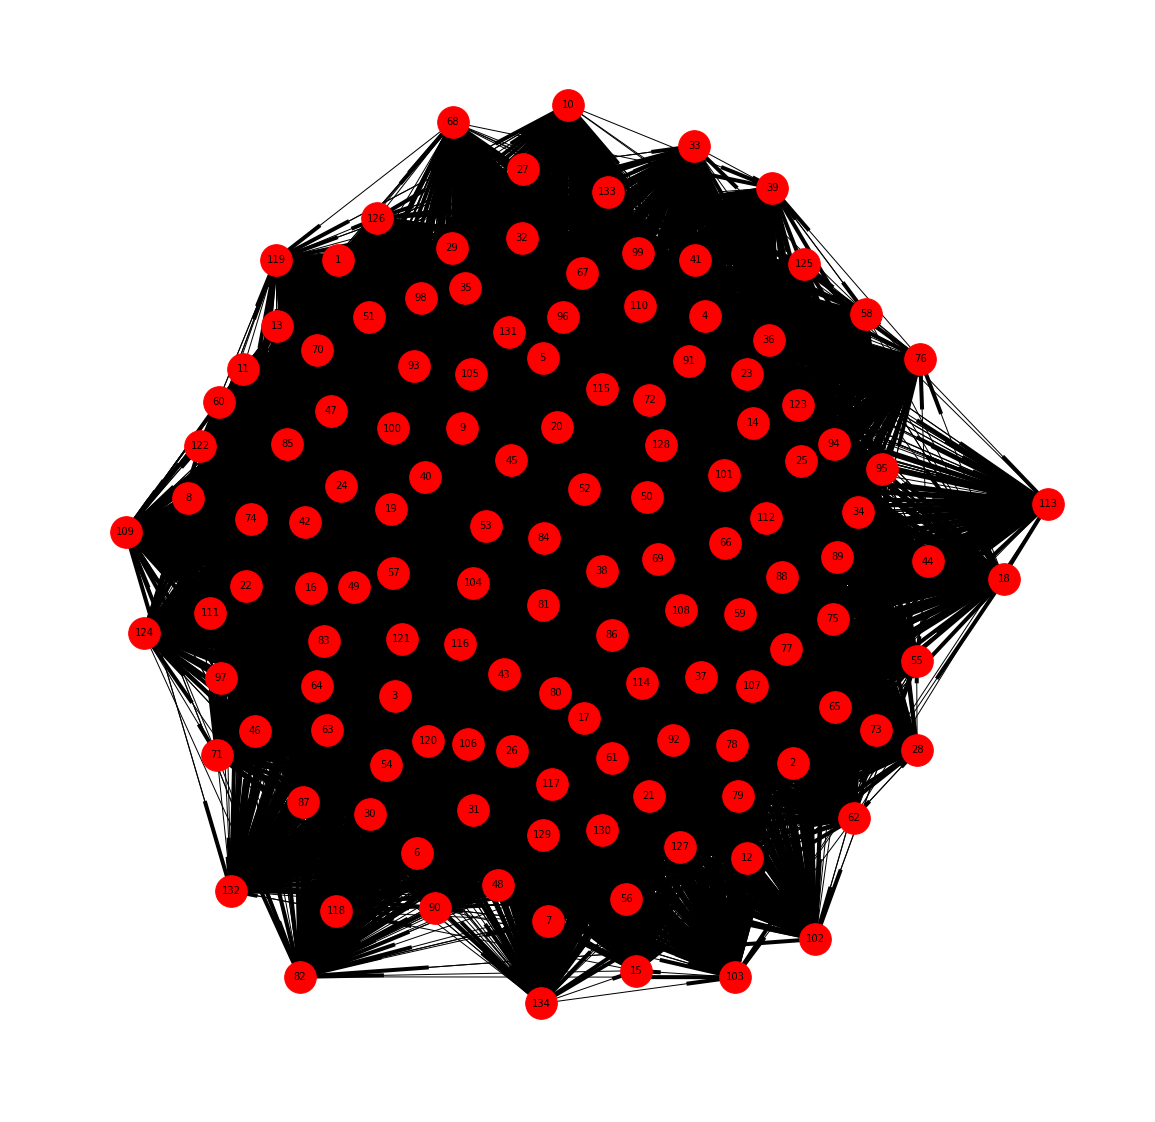

In [177]:
g = nx.DiGraph()
for aisle_id in a2a:
    for other_aisle in a2a[aisle_id]:
        if other_aisle != aisle_id:
            g.add_edge(aisle_id, other_aisle)

gfig,gax = plt.subplots(figsize=(20,20))
pos = nx.spring_layout(g,k=.3,scale=8.0,center=(0,0))
nx.draw(g,pos,ax=gax,node_size=1000,with_labels=True,font_size=10)

plt.show()

## Heat Map

In [178]:
hm = pd.DataFrame(a2a).fillna(0)

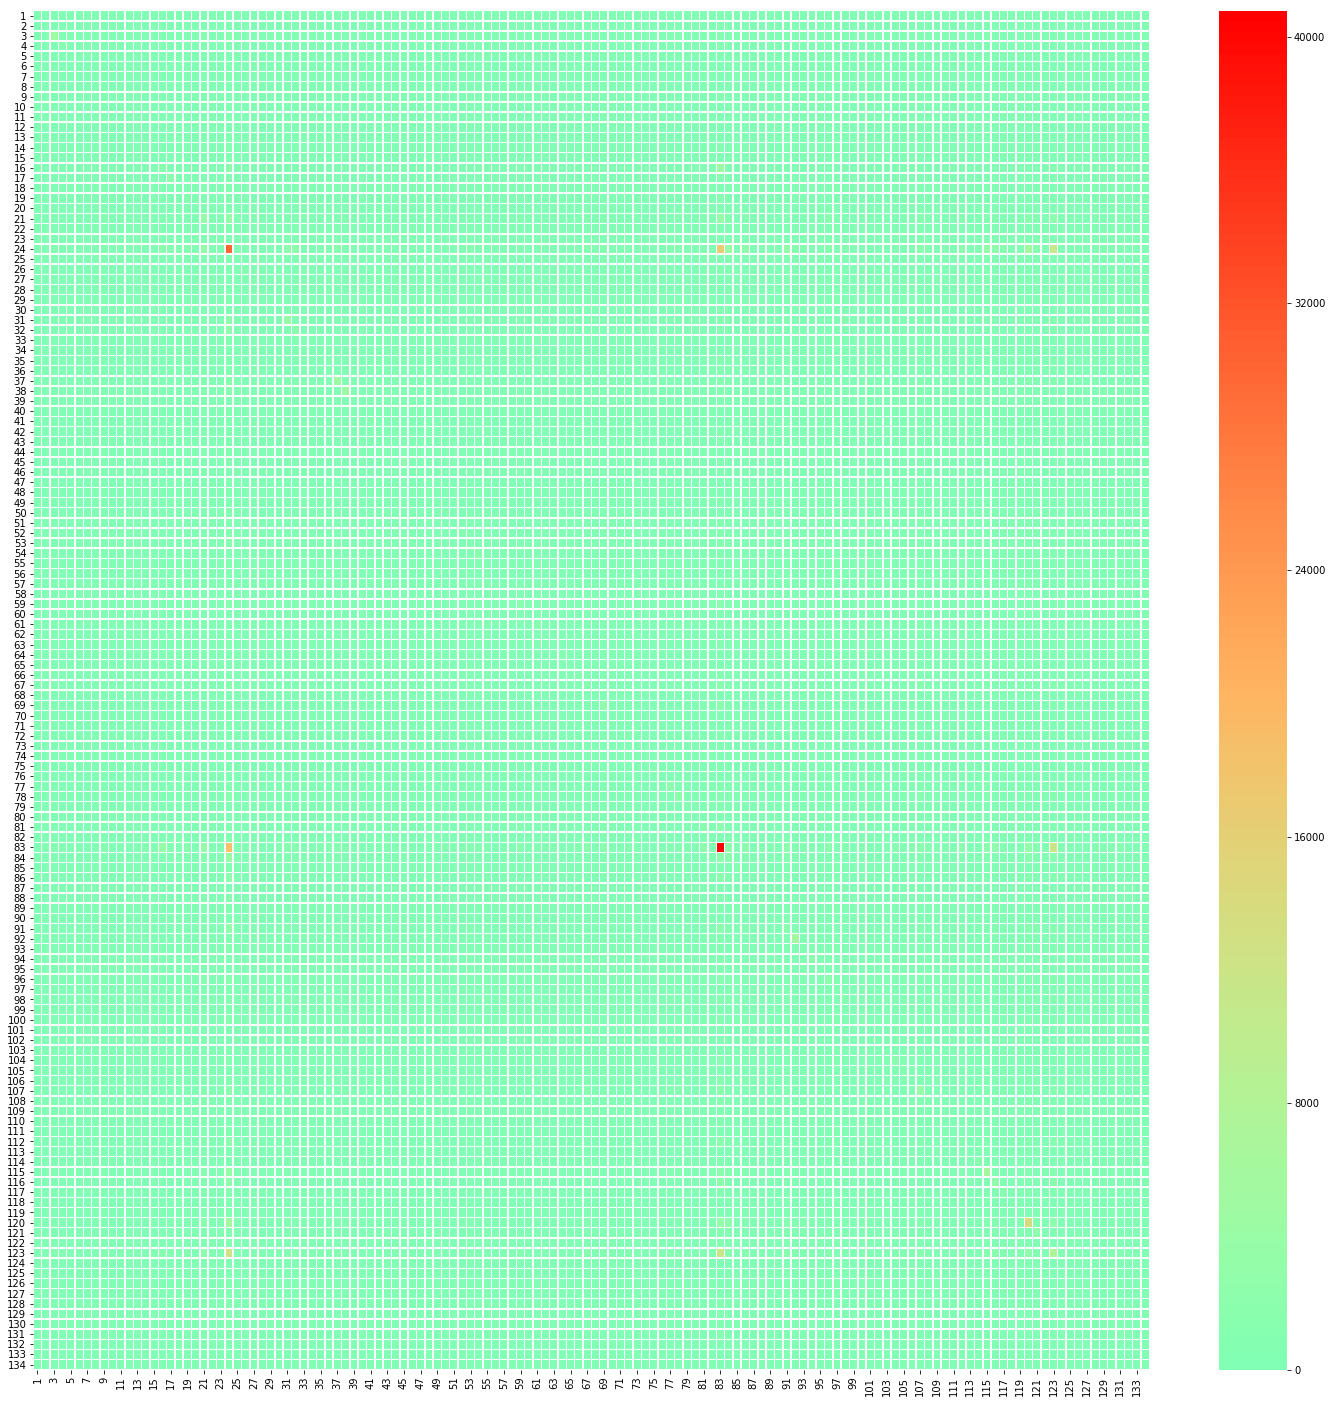

In [179]:
size = (25, 25)
fig, ax = pyplot.subplots(figsize=size)
ax = sbn.heatmap(hm, vmin=0, center=0, linewidth=.5, cmap="rainbow")

How to take the 10 most popular aisles:

- make column headers integers
- find total of each row
- sort ascending=False
- align columns numbers with row numbers
- x.values.tolist() creates a list of lists. Each list is a row in the dataframe
    - use this to grab the top 10 aisles for chord diagram
